In [1]:
import re
import os
import json
import zipfile
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import SVC


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/whats-cooking/sample_submission.csv.zip
/kaggle/input/whats-cooking/test.json.zip
/kaggle/input/whats-cooking/train.json.zip


In [2]:
with zipfile.ZipFile('/kaggle/input/whats-cooking/train.json.zip', 'r') as zf:
    with zf.open('train.json') as f:
        train = pd.read_json(f)

# Анализ данных
## Общая информация о датасете

In [3]:
train.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [4]:
train.shape

(39774, 3)

In [5]:
train.isnull().sum()

id             0
cuisine        0
ingredients    0
dtype: int64

Каждая запись включает в себя:
* id
* cuisine: тип кухни (прим. греческая, индийская, филипинская). Целевая переменная.
* список ингридиентов

Количество записей в датасете: 39774

Пропущенные значения отсутствуют.

In [6]:
INGREDIENTS = 75

unique_cuisines = set(train['cuisine'])

all_ingredients_with_cuisine = [
    (cuisine, ingredient)
    for cuisine, ingredients_list in zip(train['cuisine'], train['ingredients'])
    for ingredient in ingredients_list
]

ingredient_counts = Counter([item[1] for item in all_ingredients_with_cuisine])

most_common_ingredients = [item for item, count in ingredient_counts.most_common(INGREDIENTS)]

ingredient_cuisine_distribution = {
    ingredient: len(
        set(cuisine for cuisine, ingr in all_ingredients_with_cuisine if ingr == ingredient)
    )
    for ingredient in most_common_ingredients
}

total_cuisines = len(unique_cuisines)
ingredient_cuisine_ratios = {
    ingredient: (count / total_cuisines) * 100
    for ingredient, count in ingredient_cuisine_distribution.items()
}

sorted_ingredients = sorted(
    ingredient_cuisine_ratios.items(),
    key=lambda x: x[1],
    reverse=True
)

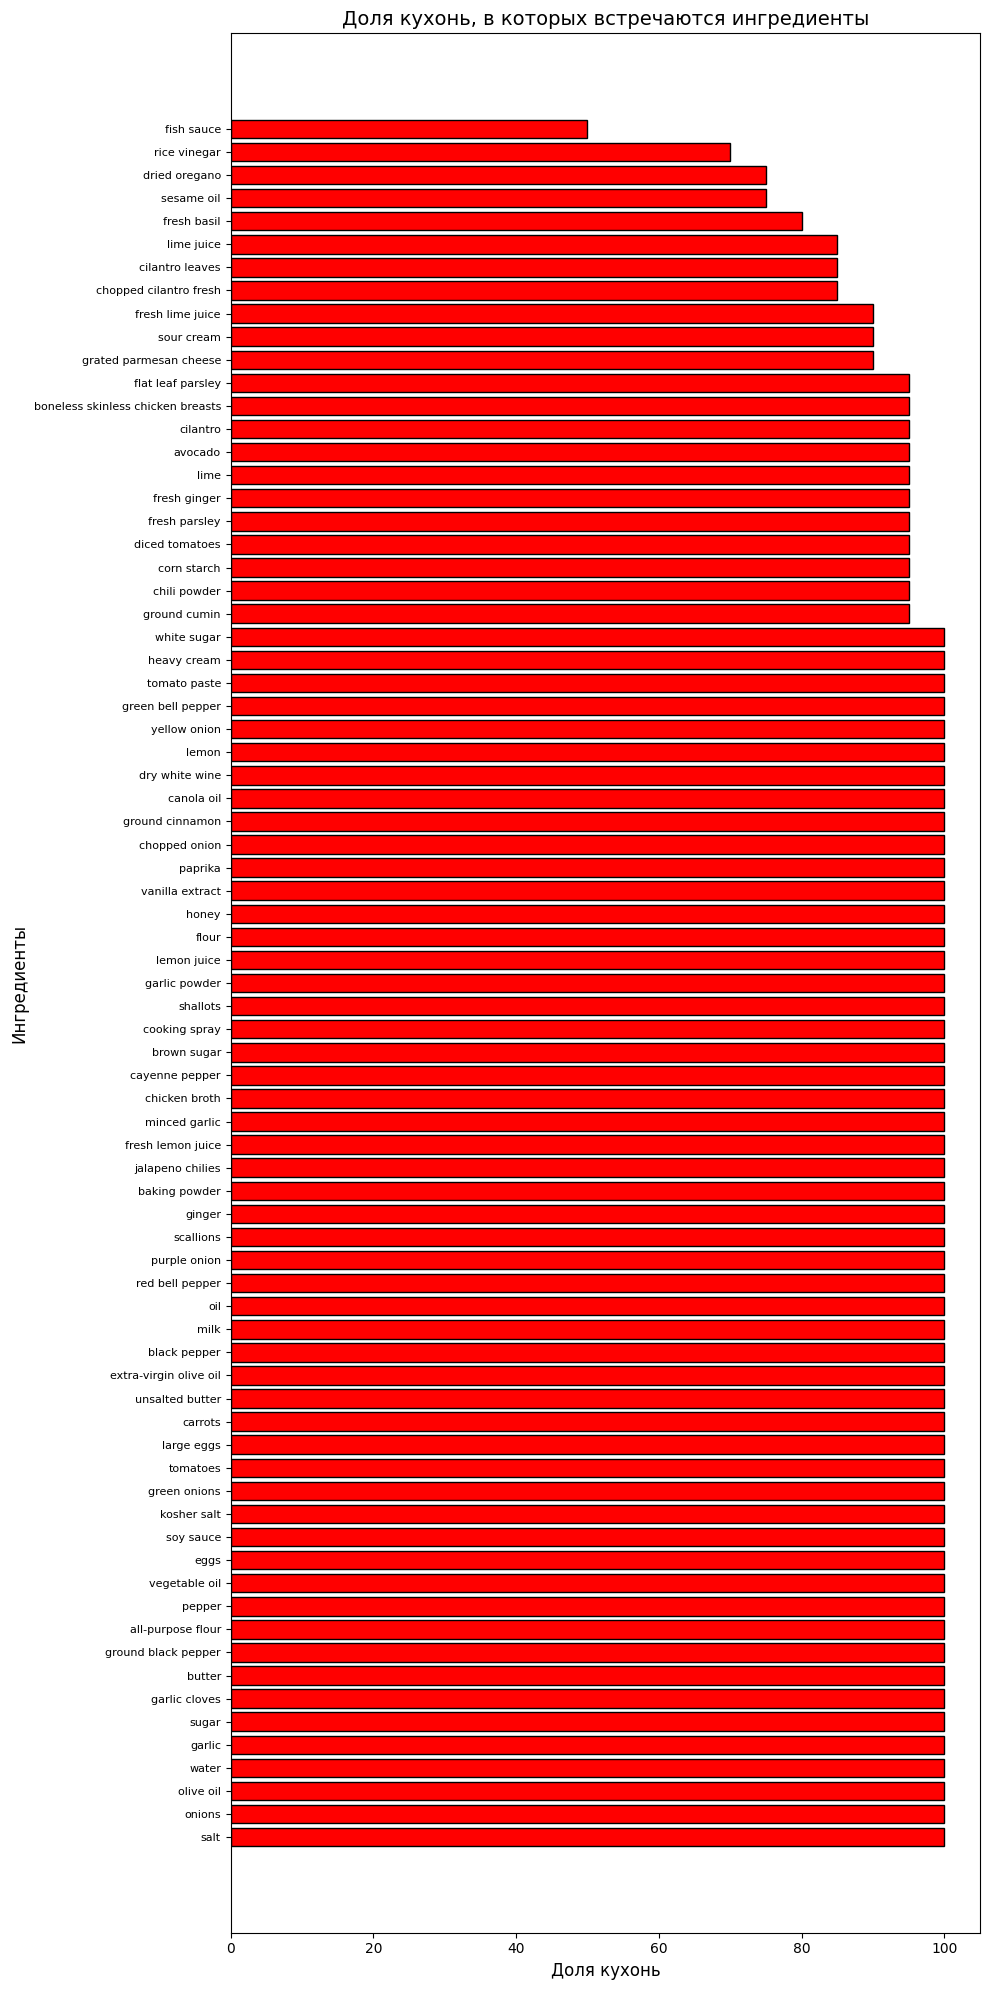

In [7]:
ingredients = [item[0] for item in sorted_ingredients]
ratios = [item[1] for item in sorted_ingredients]

ingredients = ingredients
ratios = ratios

plt.figure(figsize=(10, 20))

plt.barh(ingredients, ratios, color='red', edgecolor='black')

plt.xlabel('Доля кухонь', fontsize=12)
plt.ylabel('Ингредиенты', fontsize=12)
plt.title('Доля кухонь, в которых встречаются ингредиенты', fontsize=14)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

In [8]:
WORDS = 20

all_words = [
    word
    for ingredients in train['ingredients']
    for ingredient in ingredients
    for word in ingredient.split()
]

short_words = [word for word in all_words if len(word) <= 2]

short_word_counts = Counter(short_words)

top_short_words = short_word_counts.most_common(WORDS)

print("Наиболее частые короткие слова:")
for word, count in top_short_words:
    print(f"{word}: {count}")

Наиболее частые короткие слова:
of: 691
in: 413
&: 375
de: 232
1%: 211
2%: 85
or: 63
El: 52
el: 44
on: 30
lo: 29
I: 22
(: 20
no: 19
4: 11
up: 9
'n: 7
-: 6
au: 6
ic: 5


## Анализ кухонь

In [9]:
cuisines = train['cuisine'].value_counts()
len(cuisines)

20

In [10]:
cuisines

cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: count, dtype: int64

* Количество кухонь в датасете: 20
* Наиболее встречающаяся кухня - итальянская (7838)
* Наименее встречаюшаяся кухня - бразильская (467)

## Анализ ингредиентов

In [11]:
unique_ingredients = train['ingredients'].explode().unique()
len(unique_ingredients)

6714

In [12]:
ingredients_per_record = train['ingredients'].apply(len)

In [13]:
ingredients_per_record.min()

1

In [14]:
ingredients_per_record.max()

65

In [15]:
ingredients_per_record.mean()

10.76771257605471

In [16]:
ingredients_per_record.median()

10.0

In [17]:
ingredient_counts = train['ingredients'].explode().value_counts()

In [18]:
ingredient_counts.head(5)

ingredients
salt         18049
olive oil     7972
onions        7972
water         7457
garlic        7380
Name: count, dtype: int64

In [19]:
ingredient_counts.tail(5)

ingredients
sauerkraut juice             1
no-calorie sweetener         1
Bob Evans Italian Sausage    1
extra firm silken tofu       1
crushed cheese crackers      1
Name: count, dtype: int64

In [20]:
cuisine_ingredients = train.groupby('cuisine')['ingredients'].agg(lambda x: len(set([item for sublist in x for item in sublist]))).sort_values(ascending=False)
cuisine_ingredients

cuisine
italian         2929
mexican         2684
southern_us     2462
french          2102
chinese         1792
indian          1664
cajun_creole    1576
japanese        1439
thai            1376
spanish         1263
greek           1198
british         1166
vietnamese      1108
irish            999
moroccan         974
filipino         947
korean           898
jamaican         877
russian          872
brazilian        853
Name: ingredients, dtype: int64

* Количество различных ингридиентов - 6714
* Минимальное количество ингридиентов для одной записи - 1
* Максимальное количество ингридиентов для одной записи - 65
* Среднее значение ингридиентов для одной записи ~ 10
* Медианное значение ингридиентов для одной записи - 10
* Наиболее встречающийся ингридиент - соль
* Наименее встречающийся игридиент - измельченные сырные крекеры (и еще ~1900)
* Наиболее разнообразная кухня - итальянская
* Наименее разнообразная кухня - бразильская

## Анализ пропущенных значений

In [21]:
empty_cuisine = train['cuisine'].isnull().sum()
empty_ingredients = train['ingredients'].isnull().sum()
empty_ingredients_list = (train['ingredients'].str.len() == 0).sum()

print("Пропущенные типы кухни:", empty_cuisine)
print("Пропущенные списки ингредиентов:", empty_ingredients)
print("Пустые списки ингредиентов:", empty_ingredients_list)

Пропущенные типы кухни: 0
Пропущенные списки ингредиентов: 0
Пустые списки ингредиентов: 0


# Предобработка данных
## Преобразование целевой переменной

In [22]:
label_encoder = LabelEncoder()
train['cuisine_label_encoder'] = label_encoder.fit_transform(train['cuisine'])
train.head(10)

,id,cuisine,ingredients,cuisine_label_encoder
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",6
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",16
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",4
3,22213,indian,"[water, vegetable oil, wheat, salt]",7
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",7
5,6602,jamaican,"[plain flour, sugar, butter, eggs, fresh ginge...",10
6,42779,spanish,"[olive oil, salt, medium shrimp, pepper, garli...",17
7,3735,italian,"[sugar, pistachio nuts, white almond bark, flo...",9
8,16903,mexican,"[olive oil, purple onion, fresh pineapple, por...",13
9,12734,italian,"[chopped tomatoes, fresh basil, garlic, extra-...",9


## Преобразование ингредиентов

In [23]:
def preprocess_ingredients(ingredients):
    text = ' '.join(ingredients)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    
    return text

In [24]:
train['preprocess_ingredients'] = train['ingredients'].apply(preprocess_ingredients)

In [25]:
tfidf = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),
    analyzer="word",
    max_df=0.57,
    binary=False,
    token_pattern=r'\b\w+\b',
    sublinear_tf=False
)

ingredients_tfidf = tfidf.fit_transform(train['preprocess_ingredients'])

ingredients_tfidf_df = pd.DataFrame(
    ingredients_tfidf.toarray(),
    columns=tfidf.get_feature_names_out(),
    index=train.index
)

train_final = pd.concat([train[['id', 'cuisine', 'cuisine_label_encoder']], ingredients_tfidf_df], axis=1)

In [26]:
train_final.head()

,id,cuisine,cuisine_label_encoder,aai,aai almond,aai beets,aai coconut,aai fresh,aai frozen,aai goji,...,zucchini waxy,zucchini wheat,zucchini whipping,zucchini white,zucchini wine,zucchini wishbone,zucchini worcestershire,zucchini yellow,zucchini yukon,zucchini zucchini
0,10259,greek,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25693,southern_us,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20130,filipino,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22213,indian,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13162,indian,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Обучение модели (метод SVC)

In [27]:
X = ingredients_tfidf
y = train['cuisine_label_encoder']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
model = SVC(kernel='linear', C=1.0, random_state=42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [29]:
y_pred = model.predict(X_test)

In [30]:
precision_svc = precision_score(y_test, y_pred, average='weighted')
recall_svc = recall_score(y_test, y_pred, average='weighted')
f1_svc = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision_svc}")
print(f"Recall: {recall_svc}")
print(f"F1 Score: {f1_svc}")

Precision: 0.7888626625643961
Recall: 0.7868007542426148
F1 Score: 0.7818836609427069


# Предсказание на тестовых данных

In [31]:
with zipfile.ZipFile('/kaggle/input/whats-cooking/test.json.zip', 'r') as zf:
    with zf.open('test.json') as f:
        test_json = pd.read_json(f)

In [32]:
test_df = pd.DataFrame(test_json)
test_df['preprocess_ingredients'] = test_df['ingredients'].apply(preprocess_ingredients)
test_ingredients_tfidf = tfidf.transform(test_df['preprocess_ingredients'])

In [33]:
test_predictions = model.predict(test_ingredients_tfidf)

In [34]:
test_df['cuisine'] = label_encoder.inverse_transform(test_predictions)

In [35]:
test_df[['id', 'cuisine']].to_csv("submission.csv", index=False)

print(test_df[['id', 'cuisine']].head())

      id       cuisine
0  18009       italian
1  28583   southern_us
2  41580       italian
3  29752  cajun_creole
4  35687       italian
